# Understanding word vectors

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('max_rows', 25)
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (10, 4)

... for, like, actual poets. By [Allison Parrish](http://www.decontextualize.com/)

In this tutorial, I'm going to show you how word vectors work.

## Why word vectors for poetry?

Tzara proposed a method of composing a Dada poem: cut out the words of a text, shake them in a bag, then write down the words as you remove them at random from the bag. The very idea caused a riot and sundered the avant garde in twain (or so the story goes). For poets, word vectors are (for better or worse) a tool to help soften the blow of cut-up techniques: instead of selecting words at random, we might select units of text that are *close in meaning* to other units. This can yield poetic juxtapositions with subtle effects impossible to achieve with other techniques.

Also, it's fun!

## Animal similarity and simple linear algebra

We'll begin by considering a small subset of English: words for animals. Our task is to be able to write computer programs to find similarities among these words and the creatures they designate. To do this, we might start by making a spreadsheet of some animals and their characteristics. In Python, you'd define such a spreadsheet like this:

In [1]:
animals = [
    {'name': 'kitten', 'cuteness': 95, 'size': 15},
    {'name': 'hamster', 'cuteness': 80, 'size': 8},
    {'name': 'tarantula', 'cuteness': 8, 'size': 3},
    {'name': 'puppy', 'cuteness': 90, 'size': 20},
    {'name': 'crocodile', 'cuteness': 5, 'size': 40},
    {'name': 'dolphin', 'cuteness': 60, 'size': 45},
    {'name': 'panda bear', 'cuteness': 75, 'size': 40},
    {'name': 'lobster', 'cuteness': 2, 'size': 15},
    {'name': 'capybara', 'cuteness': 70, 'size': 30},
    {'name': 'elephant', 'cuteness': 65, 'size': 90},
    {'name': 'mosquito', 'cuteness': 1, 'size': 1},
    {'name': 'goldfish', 'cuteness': 25, 'size': 2},
    {'name': 'horse', 'cuteness': 50, 'size': 50},
    {'name': 'chicken', 'cuteness': 25, 'size': 15}
]
animal_lookup = {item['name']: (item['cuteness'], item['size']) for item in animals}

And then display it:

In [4]:
pd.DataFrame(animals, columns=['name', 'cuteness', 'size'])

,name,cuteness,size
0,kitten,95,15
1,hamster,80,8
2,tarantula,8,3
3,puppy,90,20
4,crocodile,5,40
5,dolphin,60,45
6,panda bear,75,40
7,lobster,2,15
8,capybara,70,30
9,elephant,65,90


This table associates a handful of animals with two numbers: their cuteness and their size, both in a range from zero to one hundred. (The values themselves are simply based on my own judgment. Your taste in cuteness and evaluation of size may differ significantly from mine. As with all data, these data are simply a mirror reflection of the person who collected them.)

These values give us everything we need to make determinations about which animals are similar (at least, similar in the properties that we've included in the data). Try to answer the following question: Which animal is most similar to a capybara? You could go through the values one by one and do the math to make that evaluation, but visualizing the data as points in 2-dimensional space makes finding the answer very intuitive:

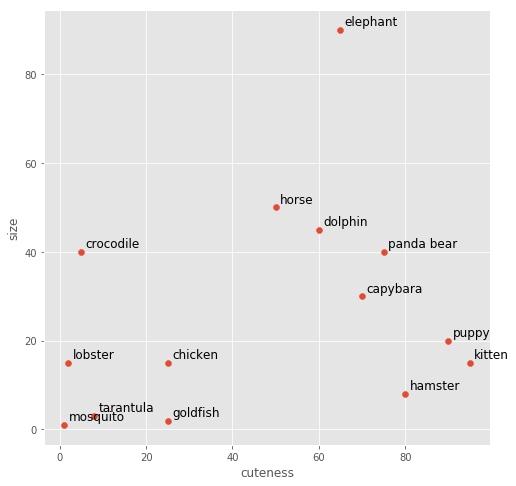

In [5]:
plt.figure(figsize=(8, 8))
plt.scatter([item[0] for item in animal_lookup.values()],
            [item[1] for item in animal_lookup.values()])
plt.xlabel('cuteness')
plt.ylabel('size')
for label, (cute, size) in animal_lookup.items():
    plt.text(cute+1, size+1, label, fontsize=12)
plt.show()

The plot shows us that the closest animal to the capybara is the panda bear (again, in terms of its subjective size and cuteness). One way of calculating how "far apart" two points are is to find their *Euclidean distance*. (This is simply the length of the line that connects the two points.) For points in two dimensions, Euclidean distance can be calculated with the following Python function:

In [6]:
import math
def distance2d(a, b):
    return math.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)

(The `**` operator raises the value on its left to the power on its right.)

So, the distance between "capybara" (70, 30) and "panda" (74, 40):

In [7]:
distance2d(animal_lookup['capybara'], animal_lookup['panda bear']) # panda and capybara

11.180339887498949

... is less than the distance between "tarantula" and "elephant":

In [8]:
distance2d(animal_lookup['tarantula'], animal_lookup['elephant']) # tarantula and elephant

104.0096149401583

Modeling animals in this way has a few other interesting properties. For example, you can pick an arbitrary point in "animal space" and then find the animal closest to that point. If you imagine an animal of size 25 and cuteness 30, you can easily look at the space to find the animal that most closely fits that description: the chicken.

Reasoning visually, you can also answer questions like: what's halfway between a chicken and an elephant? Simply draw a line from "elephant" to "chicken," mark off the midpoint and find the closest animal. (According to our chart, halfway between an elephant and a chicken is a horse.)

You can also ask: what's the *difference* between a hamster and a tarantula? According to our plot, it's about seventy five units of cute (and a few units of size).

The relationship of "difference" is an interesting one, because it allows us to reason about *analogous* relationships. In the chart below, I've drawn an arrow from "tarantula" to "hamster" (in blue):

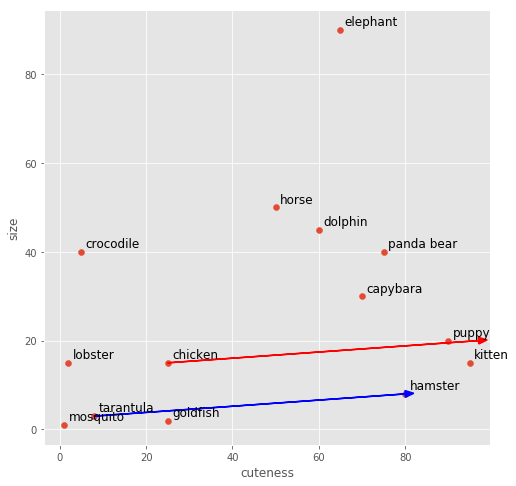

In [9]:
plt.figure(figsize=(8, 8))
plt.scatter([item[0] for item in animal_lookup.values()],
            [item[1] for item in animal_lookup.values()])
plt.xlabel('cuteness')
plt.ylabel('size')
for label, (cute, size) in animal_lookup.items():
    plt.text(cute+1, size+1, label, fontsize=12)
plt.arrow(
    *(animal_lookup['tarantula']),
    *(np.array(animal_lookup['hamster']) - np.array(animal_lookup['tarantula'])),
    fc="b", ec="b", head_width=1.5, head_length=2, linewidth=1.5)
plt.arrow(
    *(animal_lookup['chicken']),
    *(np.array(animal_lookup['hamster']) - np.array(animal_lookup['tarantula'])),
    fc="r", ec="r", head_width=1.5, head_length=2, linewidth=1.5)
plt.show()

You can understand this arrow as being the *relationship* between a tarantula and a hamster, in terms of their size and cuteness (i.e., hamsters and tarantulas are about the same size, but hamsters are much cuter). In the same diagram, I've also transposed this same arrow (this time in red) so that its origin point is "chicken." The arrow ends closest to "kitten." What we've discovered is that the animal that is about the same size as a chicken but much cuter is... a kitten. To put it in terms of an analogy:

    Tarantulas are to hamsters as chickens are to kittens.
    
A sequence of numbers used to identify a point is called a *vector*, and the kind of math we've been doing so far is called *linear algebra.* (Linear algebra is surprisingly useful across many domains: It's the same kind of math you might do to, e.g., simulate the velocity and acceleration of a sprite in a video game.)

A set of vectors that are all part of the same data set is often called a *vector space*. The vector space of animals in this section has two *dimensions*, by which I mean that each vector in the space has two numbers associated with it (i.e., two columns in the spreadsheet). The fact that this space has two dimensions just happens to make it easy to *visualize* the space by drawing a 2D plot. But most vector spaces you'll work with will have more than two dimensions—sometimes many hundreds. In those cases, it's more difficult to visualize the "space," but the math works pretty much the same.

## Language with vectors: colors

So far, so good. We have a system in place—albeit highly subjective—for talking about animals and the words used to name them. I want to talk about another vector space that has to do with language: the vector space of colors.

Colors are often represented in computers as vectors with three dimensions: red, green, and blue. Just as with the animals in the previous section, we can use these vectors to answer questions like: which colors are similar? What's the most likely color name for an arbitrarily chosen set of values for red, green and blue? Given the names of two colors, what's the name of those colors' "average"?

We'll be working with this [color data](https://github.com/dariusk/corpora/blob/master/data/colors/xkcd.json) from the [xkcd color survey](https://blog.xkcd.com/2010/05/03/color-survey-results/). The data relates a color name to the RGB value associated with that color. [Here's a page that shows what the colors look like](https://xkcd.com/color/rgb/). Download the color data and put it in the same directory as this notebook.

A few notes before we proceed:

* We're using `numpy` arrays below to implement vector arithmetic. You'll need to install `numpy` to get the examples to work. (If you used Anaconda to install Python, you have `numpy` already.) [Here's a quick introduction on how to use numpy for vector arithmetic.](https://docs.scipy.org/doc/numpy/user/quickstart.html)
* If you're interested in perceptually accurate color math in Python, consider using the [colormath library](http://python-colormath.readthedocs.io/en/latest/).

Now, import the `json` library and load the color data:

In [10]:
import json

In [11]:
color_data = json.loads(open("xkcd.json").read())

The following function converts colors from hex format (`#1a2b3c`) to a tuple of integers:

In [12]:
def hex_to_int(s):
    s = s.lstrip("#")
    return np.array([int(s[:2], 16), int(s[2:4], 16), int(s[4:6], 16)])

And the following cell creates a dictionary and populates it with mappings from color names to RGB vectors for each color in the data:

In [13]:
colors = dict()
for item in color_data['colors']:
    colors[item["color"]] = hex_to_int(item["hex"])

Testing it out:

In [14]:
colors['olive']

array([110, 117,  14])

In [15]:
colors['red']

array([229,   0,   0])

In [16]:
colors['black']

array([0, 0, 0])

In [17]:
colors['cyan']

array([  0, 255, 255])

### Vector math

Before we keep going, we'll need some functions for performing basic vector "arithmetic." These functions will work with vectors in spaces of any number of dimensions.

The first function returns the Euclidean distance between two points:

In [18]:
from numpy.linalg import norm
def distance(a, b):
    return norm(a - b)

In [19]:
distance(colors['cyan'], colors['blue'])

190.7275543805876

In [20]:
distance(np.array([10, 1]), np.array([5, 2]))

5.0990195135927845

Subtracting vectors:

In [21]:
colors['cyan'] - colors['blue']

array([ -3, 188,  32])

Adding vectors:

In [22]:
colors['cyan'] + colors['blue']

array([  3, 322, 478])

You can find the average of two vectors using the expected formula:

In [24]:
(colors['cyan'] + colors['blue']) / 2

array([  1.5, 161. , 239. ])

Or use the following function, which finds the mean of any number of vectors:

In [26]:
def meanv(vecs):
    total = np.sum(vecs, axis=0)
    return total / len(vecs)

In [27]:
meanv([colors['red'], colors['pink'], colors['maroon']])

array([195.,  43.,  75.])

Just as a test, the following cell shows that the distance from "red" to "green" is greater than the distance from "red" to "pink":

In [28]:
distance(colors['red'], colors['green']) > distance(colors['red'], colors['pink'])

True

### Finding the closest item

Just as we wanted to find the animal that most closely matched an arbitrary point in cuteness/size space, we'll want to find the closest color name to an arbitrary point in RGB space. The easiest way to find the closest item to an arbitrary vector is simply to find the distance between the target vector and each item in the space, in turn, then sort the list from closest to most distant.

Calculating the distance between two points, however, is computationally expensive, especially when you're working with data that has many dimensions. To solve this problem, computer scientists and mathematicians came up with the idea of [approximate nearest neighbor search](https://en.wikipedia.org/wiki/Nearest_neighbor_search#Approximation_methods), a technique for finding similar points in high-dimensional spaces that make use of various tricks to speed up the process (potentially at the cost of accuracy).

We're going to use a library I made called [Simple Neighbors](https://github.com/aparrish/simpleneighbors) that builds such an approximate nearest neighbors index to quickly return the closest items for any given vector. (Simple Neighbors is based on [Annoy](https://pypi.python.org/pypi/annoy).)

Install Simple Neighbors like so:

In [180]:
!pip install simpleneighbors

You are using pip version 9.0.3, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


If you get an error from the above, and you're using Anaconda, you can try installing the Anaconda package:

In [ ]:
!conda install -y -c conda-forge python-annoy 

If neither of those works—especially if you're using Windows—you may need to install a C++ compiler, or you can use this notebook on Binder. (If you're a student, come see me for more info.)

Once you have the library installed, import it like so:

In [29]:
from simpleneighbors import SimpleNeighbors

The first parameter to `SimpleNeighbors()` is the number of dimensions in the data; the second is the distance metric to use. (This defaults to cosine distance, but in this case we want to use Euclidean distance.)

The `.add_one()` method adds an item and a vector to the index. Once all the items are added, `.build()` actually builds the index. This should go quick, since we don't have that much data!

In [30]:
color_lookup = SimpleNeighbors(3, 'euclidean')
for name, vec in colors.items():
    color_lookup.add_one(name, vec)
color_lookup.build()

To find the nearest item to a specified vector, pass the vector to the `.nearest()` method:

In [31]:
color_lookup.nearest(colors['red'])

['red',
 'fire engine red',
 'bright red',
 'tomato red',
 'cherry red',
 'scarlet',
 'vermillion',
 'orangish red',
 'cherry',
 'lipstick red',
 'darkish red',
 'neon red']

Limit the number of results returned with the second parameter:

In [32]:
color_lookup.nearest(colors['red'], 3)

['red', 'fire engine red', 'bright red']

Here are the colors closest to (150, 60, 150):

In [33]:
color_lookup.nearest([150, 60, 150])

['warm purple',
 'medium purple',
 'ugly purple',
 'light eggplant',
 'purpleish',
 'purplish',
 'purply',
 'light plum',
 'purple',
 'muted purple',
 'dusty purple',
 'dusky purple']

The `.dist()` method gives the distance between two items in the index:

In [34]:
color_lookup.dist('rose', 'pink')

94.28679656982422

In [35]:
color_lookup.dist('green', 'purple')

221.90313720703125

And you can check the `.corpus` attribute to see if an item is even in the index to begin with:

In [36]:
'orange' in color_lookup.corpus

True

In [37]:
'kitten' in color_lookup.corpus

False

### Color magic

The magical part of representing words as vectors is that the vector operations we defined earlier appear to operate on language the same way they operate on numbers. For example, if we find the word closest to the vector resulting from subtracting "red" from "purple," we get a series of "blue" colors:

In [38]:
color_lookup.nearest(colors['purple'] - colors['red'])

['cobalt blue',
 'royal blue',
 'darkish blue',
 'true blue',
 'royal',
 'prussian blue',
 'dark royal blue',
 'deep blue',
 'marine blue',
 'deep sea blue',
 'darkblue',
 'twilight blue']

This matches our intuition about RGB colors, which is that purple is a combination of red and blue. Take away the red, and blue is all you have left.

You can do something similar with addition. What's blue plus green?

In [39]:
color_lookup.nearest(colors['blue'] + colors['green'])

['bright turquoise',
 'bright light blue',
 'bright aqua',
 'cyan',
 'neon blue',
 'aqua blue',
 'bright cyan',
 'bright sky blue',
 'aqua',
 'bright teal',
 'aqua marine',
 'greenish cyan']

That's right, it's something like turquoise or cyan! What if we find the average of black and white? Predictably, we get gray:

In [40]:
# the average of black and white: medium grey
color_lookup.nearest(meanv([colors['white'], colors['black']]))

['medium grey',
 'purple grey',
 'steel grey',
 'battleship grey',
 'grey purple',
 'purplish grey',
 'greyish purple',
 'steel',
 'warm grey',
 'green grey',
 'brown grey',
 'bluish grey']

Just as with the tarantula/hamster example from the previous section, we can use color vectors to reason about relationships between colors. In the cell below, finding the difference between "pink" and "red" then adding it to "blue" seems to give us a list of colors that are to blue what pink is to red (i.e., a slightly lighter, less saturated shade):

In [41]:
# an analogy: pink is to red as X is to blue
pink_to_red = colors['pink'] - colors['red']
color_lookup.nearest(pink_to_red + colors['blue'])

['neon blue',
 'bright sky blue',
 'bright light blue',
 'cyan',
 'bright cyan',
 'bright turquoise',
 'clear blue',
 'azure',
 'dodger blue',
 'lightish blue',
 'sky blue',
 'aqua blue']

Another example of color analogies: Navy is to blue as true green/dark grass green is to green:

In [42]:
# another example: 
navy_to_blue = colors['navy'] - colors['blue']
color_lookup.nearest(navy_to_blue + colors['green'])

['true green',
 'dark grass green',
 'grassy green',
 'racing green',
 'forest',
 'bottle green',
 'dark olive green',
 'darkgreen',
 'forrest green',
 'grass green',
 'navy green',
 'deep green']

The examples above are fairly simple from a mathematical perspective but nevertheless *feel* magical: they're demonstrating that it's possible to use math to reason about how people use language.

### Interlude: A Love Poem That Loses Its Way

In [43]:
import random
red = colors['red']
blue = colors['blue']
for i in range(14):
    rednames = color_lookup.nearest(red)
    bluenames = color_lookup.nearest(blue)
    print("Roses are " + rednames[0] + ", violets are " + bluenames[0])
    red = colors[random.choice(rednames[1:])]
    blue = colors[random.choice(bluenames[1:])]

Roses are red, violets are blue
Roses are neon red, violets are vivid blue
Roses are lightish red, violets are rich blue
Roses are neon red, violets are blue
Roses are red pink, violets are blue blue
Roses are pink red, violets are blurple
Roses are cerise, violets are bluish purple
Roses are ruby, violets are blurple
Roses are lipstick, violets are purpley blue
Roses are red pink, violets are blue with a hint of purple
Roses are pinky red, violets are dark periwinkle
Roses are tomato, violets are blue with a hint of purple
Roses are reddish orange, violets are purpley blue
Roses are orange red, violets are purple blue


### Doing bad digital humanities with color vectors

With the tools above in hand, we can start using our vectorized knowledge of language toward academic ends. In the following example, I'm going to calculate the average color of Mary Shelley's *Frankenstein*.

(Before you proceed, make sure to [download the text file from Project Gutenberg](http://www.gutenberg.org/files/84/84-0.txt) and place it in the same directory as this notebook.)

First, we'll load [spaCy](https://spacy.io/). (Note: For the rest of this tutorial to work, you'll want to download at least the medium model for English. The default "small" model doesn't include word vectors.)

In [44]:
import spacy
nlp = spacy.load('en_core_web_md')

To calculate the average color, we'll follow these steps:

1. Parse the text into words
2. Check every word to see if it names a color in our vector space. If it does, add it to a list of vectors.
3. Find the average of that list of vectors.
4. Find the color(s) closest to that average vector.

The following cell performs steps 1-3:

In [45]:
doc = nlp(open("84-0.txt").read())
# use word.lower_ to normalize case
drac_colors = [colors[word.lower_] for word in doc if word.lower_ in colors]
avg_color = meanv(drac_colors)
print(avg_color)

[125.52050473 134.0851735  121.63722397]


Now, we'll pass the averaged color vector to the `closest()` function, yielding... well, it's just a grey mush, which is kinda what you'd expect from adding a bunch of colors together willy-nilly.

In [46]:
color_lookup.nearest(avg_color)

['medium grey',
 'green grey',
 'steel grey',
 'grey green',
 'brown grey',
 'battleship grey',
 'greeny grey',
 'purple grey',
 'warm grey',
 'grey/green',
 'slate green',
 'steel']

On the other hand, here's what we get when we average the colors of Charlotte Perkins Gilman's classic *The Yellow Wallpaper*. ([Download from here](http://www.gutenberg.org/cache/epub/1952/pg1952.txt) and save in the same directory as this notebook if you want to follow along.) The result definitely reflects the content of the story, so maybe we're on to something here.

In [47]:
doc = nlp(open("1952-0.txt").read())
wallpaper_colors = [colors[word.lower_] for word in doc if word.lower_ in colors]
avg_color = meanv(wallpaper_colors)
color_lookup.nearest(avg_color)

['pea',
 'puke yellow',
 'sick green',
 'vomit yellow',
 'booger',
 'olive yellow',
 'snot',
 'gross green',
 'dirty yellow',
 'mustard yellow',
 'dark yellow',
 'baby puke green']

Exercise for the reader: Use the vector arithmetic functions to rewrite a text, making it...

* more blue (i.e., add `colors['blue']` to each occurrence of a color word); or
* more light (i.e., add `colors['white']` to each occurrence of a color word); or
* darker (i.e., attenuate each color. You might need to write a vector multiplication function to do this one right.)

## Distributional semantics

In the previous section, the examples are interesting because of a simple fact: colors that we think of as similar are "closer" to each other in RGB vector space. In our color vector space, or in our animal cuteness/size space, you can think of the words identified by vectors close to each other as being *synonyms*, in a sense: they sort of "mean" the same thing. They're also, for many purposes, *functionally identical*. Think of this in terms of writing, say, a search engine. If someone searches for "mauve trousers," then it's probably also okay to show them results for, say,

In [48]:
for cname in color_lookup.nearest(colors['mauve']):
    print(cname + " trousers")

mauve trousers
dusty rose trousers
dusky rose trousers
brownish pink trousers
old pink trousers
reddish grey trousers
dirty pink trousers
old rose trousers
light plum trousers
ugly pink trousers
pinkish brown trousers
dusky pink trousers


That's all well and good for color words, which intuitively seem to exist in a multidimensional continuum of perception, and for our animal space, where we've written out the vectors ahead of time. But what about... arbitrary words? Is it possible to create a vector space for all English words that has this same "closer in space is closer in meaning" property?

To answer that, we have to back up a bit and ask the question: what does *meaning* mean? No one really knows, but one theory popular among computational linguists, computer scientists and other people who make search engines is the [Distributional Hypothesis](https://en.wikipedia.org/wiki/Distributional_semantics), which states that:

    Linguistic items with similar distributions have similar meanings.
    
What's meant by "similar distributions" is *similar contexts*. Take for example the following sentences:

    It was really cold yesterday.
    It will be really warm today, though.
    It'll be really hot tomorrow!
    Will it be really cool Tuesday?
    
According to the Distributional Hypothesis, the words `cold`, `warm`, `hot` and `cool` must be related in some way (i.e., be close in meaning) because they occur in a similar context, i.e., between the word "really" and a word indicating a particular day. (Likewise, the words `yesterday`, `today`, `tomorrow` and `Tuesday` must be related, since they occur in the context of a word indicating a temperature.)

In other words, according to the Distributional Hypothesis, a word's meaning is just a big list of all the contexts it occurs in. Two words are closer in meaning if they share contexts.

## Word vectors by counting contexts

So how do we turn this insight from the Distributional Hypothesis into a system for creating general-purpose vectors that capture the meaning of words? Maybe you can see where I'm going with this. What if we made a *really big* spreadsheet that had one column for every context for every word in a given source text. Let's use a small source text to begin with, such as this excerpt from Dickens:

    It was the best of times, it was the worst of times.

Such a spreadsheet might look something like this:

![dickens contexts](http://static.decontextualize.com/snaps/best-of-times.png)

The spreadsheet has one column for every possible context, and one row for every word. The values in each cell correspond with how many times the word occurs in the given context. The numbers in the columns constitute that word's vector, i.e., the vector for the word `of` is

    [0, 0, 0, 0, 1, 0, 0, 0, 1, 0]
    
Because there are ten possible contexts, this is a ten dimensional space! It might be strange to think of it, but you can do vector arithmetic on vectors with ten dimensions just as easily as you can on vectors with two or three dimensions, and you could use the same distance formula that we defined earlier to get useful information about which vectors in this space are similar to each other. In particular, the vectors for `best` and `worst` are actually the same (a distance of zero), since they occur only in the same context (`the ___ of`):

    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
    
Of course, the conventional way of thinking about "best" and "worst" is that they're *antonyms*, not *synonyms*. But they're also clearly two words of the same kind, with related meanings (through opposition), a fact that is captured by this distributional model.

### Contexts and dimensionality

Of course, in a corpus of any reasonable size, there will be many thousands if not many millions of possible contexts. It's difficult enough working with a vector space of ten dimensions, let alone a vector space of a million dimensions! It turns out, though, that many of the dimensions end up being superfluous and can either be eliminated or combined with other dimensions without significantly affecting the predictive power of the resulting vectors. The process of getting rid of superfluous dimensions in a vector space is called [dimensionality reduction](https://en.wikipedia.org/wiki/Dimensionality_reduction), and most implementations of count-based word vectors make use of dimensionality reduction so that the resulting vector space has a reasonable number of dimensions (say, 100—300, depending on the corpus and application).

The question of how to identify a "context" is itself very difficult to answer. In the toy example above, we've said that a "context" is just the word that precedes and the word that follows. Depending on your implementation of this procedure, though, you might want a context with a bigger "window" (e.g., two words before and after), or a non-contiguous window (skip a word before and after the given word). You might exclude certain "function" words like "the" and "of" when determining a word's context, or you might [lemmatize](https://en.wikipedia.org/wiki/Lemmatisation) the words before you begin your analysis, so two occurrences with different "forms" of the same word count as the same context. These are all questions open to research and debate, and different implementations of procedures for creating count-based word vectors make different decisions on this issue.

### GloVe vectors

But you don't have to create your own word vectors from scratch! Many researchers have made downloadable databases of pre-trained vectors. One such project is Stanford's [Global Vectors for Word Representation (GloVe)](https://nlp.stanford.edu/projects/glove/). These 300-dimensional vectors are included with spaCy, and they're the vectors we'll be using for the rest of this tutorial.

## Word vectors in spaCy

Okay, let's have some fun with real word vectors. We're going to use the GloVe vectors that come with spaCy to creatively analyze and manipulate the text of *Frankenstein*. First, make sure you've got `spacy` imported:

In [135]:
import spacy

The following cell loads the language model:

In [32]:
nlp = spacy.load('en_core_web_md')

You can see the vector of any word in spaCy's vocabulary using the `vocab` attribute, like so:

In [49]:
nlp.vocab['kitten'].vector

array([-2.2743e-01, -5.1464e-02, -4.3421e-02, -1.0523e-01, -3.3389e-01,
       -4.9611e-01, -6.4342e-01, -4.6994e-01,  3.9693e-01,  8.4902e-01,
       -4.0845e-01, -1.8312e-01, -6.2564e-01, -1.0160e-01, -3.6914e-01,
        6.8634e-01,  2.6607e-01,  3.2985e-01, -9.8570e-02, -1.3281e-01,
       -4.7505e-01, -1.9249e-01, -3.1917e-01, -1.8536e-01,  1.1118e-01,
        7.3772e-02, -3.0407e-01, -2.7552e-01,  6.1108e-01, -3.6344e-01,
       -4.5849e-01, -1.2872e-01,  1.5175e-01,  3.3248e-01,  3.0900e-01,
       -2.8488e-01,  2.5544e-01, -9.4332e-01, -5.5746e-01,  5.8764e-02,
        1.1174e-01,  2.0032e-01, -4.1090e-01, -5.4444e-01, -4.3831e-02,
        1.6265e-01, -6.8028e-01,  2.8266e-01,  1.8177e-01, -5.6184e-01,
        7.0911e-02, -3.4996e-01, -3.1639e-01,  1.7666e-01, -9.4568e-03,
        4.4389e-01,  7.6684e-02, -2.1797e-01,  1.3728e-03,  2.3474e-01,
       -1.8564e-01, -4.2277e-01,  2.5585e-01, -6.2553e-01, -1.4335e-01,
       -1.8835e-01,  3.5240e-01,  2.0764e-01,  8.8644e-02, -2.08

spaCy's English model uses 300-dimensional pre-trained GloVe vectors.

For the sake of convenience, the following function gets the vector of a given string from spaCy's vocabulary:

In [50]:
def vec(s):
    return nlp.vocab[s].vector

Another thing about spaCy vocab items: they have a `.prob` attribute that tells you the "log probability" of the token (i.e., its unigram frequency, passed to the `log()` function to make it more "numerically stable"). Basically, the closer to zero, the more common the word is; the further away from zero, the less common.

In [51]:
nlp.vocab["me"].prob

-5.846089839935303

In [52]:
nlp.vocab["kitten"].prob

-12.040445327758789

In [53]:
nlp.vocab["zymurgy"].prob

-19.401931762695312

Unknown tokens are assigned `-20.0`:

In [54]:
nlp.vocab["QOWEIFAKLSDHF"].prob

-20.0

## Looking up synonyms

Here I make a `SimpleNeighbors` index that loads in all words from spaCy's vocab that (a) have an associated vector; (b) have a log probability greater than -15; (c) are lower case. (All but the first of these criteria are arbitrary; feel free to experiment.)

In [207]:
lookup = SimpleNeighbors(300)
for item in nlp.vocab:
    if item.has_vector and item.prob > -15 and item.is_lower:
        lookup.add_one(item.text, item.vector)
lookup.build()

In [208]:
len(lookup)

32051

Now we can get synonyms for words by looking up the word's vector and finding the nearest word in the index:

In [223]:
lookup.nearest(vec('basketball'))

['volleyball',
 'lacrosse',
 'basketball',
 'bball',
 'football',
 'footballing',
 'handball',
 'soccer',
 'softball',
 'baseball',
 'hockey',
 'racket']

### Fun with spaCy and vector arithmetic

Now we can start doing vector arithmetic and finding the closest words to the resulting vectors. For example, what word is closest to the halfway point between day and night?

In [224]:
# halfway between day and night
lookup.nearest(meanv([vec("day"), vec("night")]))

['night',
 'day',
 'evening',
 'morning',
 'midday',
 'afternoon',
 'nights',
 'outing',
 'weekend',
 'days',
 'hour',
 'yesterday']

Variations of `night` and `day` are still closest, but after that we get words like `evening` and `morning`, which are indeed halfway between day and night!

Here are the closest words in *Frankenstein* to "wine":

In [226]:
lookup.nearest(vec("wine"))

['wine',
 'wines',
 'tasting',
 'sparkling',
 'champagne',
 'lager',
 'beer',
 'dropper',
 'jug',
 'bottle',
 'drink',
 'beverages']

If you subtract "alcohol" from "wine" and find the closest words to the resulting vector, you're left with simply a lovely dinner:

In [227]:
lookup.nearest(vec("wine") - vec("alcohol"))

['chef',
 'chefs',
 'platters',
 'dishes',
 'delicious',
 'decadent',
 'savory',
 'dessert',
 'desserts',
 'italian',
 'carte',
 'buffet']

The closest words to "water":

In [228]:
lookup.nearest(vec("water"))

['seawater',
 'water',
 'dry',
 'solvent',
 'dispensing',
 'liquid',
 'heat',
 'heats',
 'gallons',
 'cubic',
 'quarts',
 'litres']

But if you add "frozen" to "water," you get "ice":

In [241]:
lookup.nearest(vec("water") + vec("freezing"))

['seawater',
 'water',
 'freezing',
 'cold',
 'chilly',
 'heat',
 'heats',
 'dry',
 'drying',
 'ice',
 'solvent',
 'dispensing']

You can even do analogies! For example, the words most similar to "grass":

In [235]:
lookup.nearest(vec("grass"))

['grass',
 'sod',
 'grassy',
 'mulch',
 'perennial',
 'overgrown',
 'weeds',
 'herbicide',
 'saplings',
 'trees',
 'foliage',
 'bushes']

If you take the difference of "blue" and "sky" and add it to grass, you get the analogous word ("green"):

In [236]:
# analogy: blue is to sky as X is to grass
blue_to_sky = vec("blue") - vec("sky")
lookup.nearest(blue_to_sky + vec("grass"))

['green',
 'yellow',
 'red',
 'periwinkle',
 'violet',
 'burgundy',
 'teal',
 'magenta',
 'purple',
 'pink',
 'blue',
 'indigo']

## Replace with synonym

The following example replaces all nouns, verbs and adjectives with a closely-related word from the synonym lookup.

In [256]:
frost_doc = nlp(open("frost.txt").read())

In [257]:
output = []
for word in frost_doc:
    if word.is_alpha and word.pos_ in ('NOUN', 'VERB', 'ADJ'):
        new_word = random.choice(lookup.nearest(word.vector, 3))
        output.append(new_word)
    else:
        output.append(word.text)
    output.append(word.whitespace_)
print(''.join(output))

Two roads diverged in a blue wood,
And sorry I would not vacations both
And should one traveler, long I sprang
And looked down one as far as I would
To where it thrusting in the cacti;

Then took the different, as just as good,
And being perhaps the much claimed,
Because it was grassy and did wearer;
Though as for that the passing there
was wearing them really about the same,

And both that midday equally lay
In sprouted no step was treads white.
Oh, I still the first for another day!
Yet mind how going continues on to it,
I doubting if I must ever they back.

I must should telling this with a sighs
Somewhere young and young hence:
Two roads originates in a veneer, and I—
I took the same less traveled by,
And that is made all the comparing.



## Tinting meaning

In [259]:
target_word = 'college'
factor = 0.25

In [261]:
output = []
for word in frost_doc:
    if word.is_alpha and word.pos_ in ('NOUN', 'VERB', 'ADJ'):
        new_word = random.choice(lookup.nearest((word.vector*(1-factor)) + (vec(target_word)*factor)))
        output.append(new_word)
    else:
        output.append(word.text)
    output.append(word.whitespace_)
print(''.join(output))

Two roads emergence in a turquoise mahogany,
And sorry I have not trips both
And if one collegiate, long I went
And turned down one as far as I probably
To where it shoulders in the foliage;

Then bagged the local, as just as want,
And one perhaps the enough that,
Because it went gardening and going too;
Though as for that the catch there
did wore them really about the that,

And both that evening equally away
In out no foward had denier sexy.
Oh, I being the collegiate for another every!
Yet understand how way three on to make,
I regret if I would ever coming back.

I permissible already someone this with a oh
Somewhere teenagers and age hence:
Two potholes cultural in a woodwork, and I—
I spent the only less visited by,
And that being had every the much.



## Semantic similarity search

Every spaCy span (documents, sentences) has a `.vector` attribute that gives a "summary" vector for the span in question. (By default, this is calculated by averaging together all of the vectors.)

In [289]:
sent = nlp("Programming computers is fun!")

In [290]:
sent.vector[:50]

array([-0.10907819,  0.1513352 ,  0.21237247, -0.15321401,  0.10914759,
        0.0173588 ,  0.085984  , -0.2554782 ,  0.2094306 ,  1.6558399 ,
       -0.09052315, -0.13296959,  0.0342764 ,  0.1505686 , -0.06614681,
       -0.15527579, -0.1310828 ,  1.5044279 , -0.2026544 , -0.0886392 ,
        0.0499612 , -0.1545334 , -0.1006914 ,  0.05445926,  0.26057976,
       -0.00777239,  0.08823   , -0.0272476 ,  0.12919   , -0.12125119,
       -0.24510416, -0.23006658,  0.09576257,  0.02779341,  0.157128  ,
        0.10950659, -0.05011179,  0.319652  , -0.01529707,  0.05117084,
        0.0409314 ,  0.167218  ,  0.0371664 ,  0.017644  ,  0.0630136 ,
        0.27724802, -0.22601199, -0.0900348 ,  0.231374  ,  0.01768318],
      dtype=float32)

Interestingly, we can find the single word closest in meaning to this sequence of words:

In [291]:
lookup.nearest(sent.vector)

['be',
 'every',
 'work',
 'now',
 'only',
 'more',
 'course',
 'program',
 'working',
 'day',
 'writing',
 'composing']

Let's find the sentence in our text file that is closest in "meaning" to an arbitrary input sentence. First, we'll get the list of sentences:

In [275]:
doc = nlp(open("./84-0.txt").read())

In [279]:
sentence_lookup = SimpleNeighbors(300)
for sent in doc.sents:
    sentence_lookup.add_one(sent.text.replace("\n", " "), sent.vector)
sentence_lookup.build()

In [285]:
sentence_lookup.nearest(nlp("My favorite food is strawberry ice cream.").vector)

['When they had retired to rest, if there was any moon or the night was star-light, I went into the woods and collected my own food and fuel for the cottage.  ',
 'This roused me from my nearly dormant state, and I ate some berries which I found hanging on the trees or lying on the ground.  ',
 'Below this picture was a miniature of William; and my tears flowed when I looked upon it.',
 'I was still cold when under one of the trees I found a huge cloak, with which I covered myself, and sat down upon the ground.  ',
 'I could now almost fancy myself among the Swiss mountains.  ',
 'I lay at the bottom of the boat, and as I gazed on the cloudless blue sky, I seemed to drink in a tranquillity to which I had long been a stranger.',
 'I wish you could see him; he is very tall of his age, with sweet laughing blue eyes, dark eyelashes, and curling hair.  ',
 'About five in the morning I discovered my lovely boy, whom the night before I had seen blooming and active in health, stretched on the 

A noun chunk lookup:

In [317]:
chunk_lookup = SimpleNeighbors(300)
for chunk in doc.noun_chunks:
    chunk_lookup.add_one(chunk.text.replace("\n", " "), chunk.vector)
chunk_lookup.build()

In [318]:
chunk_lookup.nearest(nlp("spooky birds").vector)

['stately deer',
 'its beautiful forest',
 'the bleak forest',
 'beautiful scenery',
 'trees',
 'trees',
 'the dark mountains',
 'the beautiful lake',
 'the cloudless blue sky',
 'the pine woods',
 'the most verdant islands',
 'the scenery']

In [310]:
adj_lookup = SimpleNeighbors(300)
for word in doc:
    if word.tag_ == 'JJ' and word.text not in adj_lookup.corpus:
        adj_lookup.add_one(word.text, word.vector)
adj_lookup.build()

In [311]:
len(adj_lookup)

1274

In [313]:
adj_lookup.nearest(vec("awful"))

['awful',
 'horrible',
 'terrible',
 'horrid',
 'dreadful',
 'bad',
 'atrocious',
 'hideous',
 'Hideous',
 'ghastly',
 'hideousness',
 'repulsive']

### Rewriting with parts of speech from another text

In [314]:
frost_doc = nlp(open("frost.txt").read())

In [319]:
output = []
for word in frost_doc:
    if word.is_alpha and word.pos_ == 'NOUN':
        new_word = random.choice(chunk_lookup.nearest(word.vector, 5))
        output.append(new_word)
    elif word.is_alpha and word.tag_ == 'JJ':
        new_word = random.choice(adj_lookup.nearest(word.vector, 5))
        output.append(new_word)
    else:
        output.append(word.text)
    output.append(word.whitespace_)
print(''.join(output))

Two populous towns diverged in a yellow wood,
And sorry I could not travel both
And be one exquisite pleasure, long I stood
And looked down one as far as I could
To where it bent in the dark-leaved brambles;

Then took the many, as just as honest,
And having perhaps the better any argument,
Because it was wet and wanted my neck;
Though as for that the the path there
Had worn them really about the only,

And both that morning equally lay
In dark-leaved brambles no some steps had trodden black.
Oh, I kept the first for another day!
Yet knowing how way leads on to way,
I doubted if I should ever come back.

I shall be telling this with a angry countenances
Somewhere age and age hence:
Two these rugged roads diverged in a wood, and I—
I took the one less travelled by,
And that has made all the a far different effect.

